#### Qual embedding?

In [1]:
TABLE = "rag_embeddings_s"

https://python.langchain.com/docs/tutorials/rag/

In [1]:
import os
from dotenv import load_dotenv
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_google_community import BigQueryVectorStore
import csv
from langchain_community.document_loaders import WebBaseLoader
import bs4
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image
from langchain_core.messages import SystemMessage

In [3]:
load_dotenv()
assert "LANGSMITH_TRACING" in os.environ, "Please set the LANGSMITH_TRACING environment variable."
assert "LANGSMITH_API_KEY" in os.environ, "Please set the LANGSMITH_API_KEY environment variable."
assert "PROJECT_ID" in os.environ, "Please set the PROJECT_ID environment variable."
assert "LOCATION" in os.environ, "Please set the LOCATION environment variable."
assert "DATASET" in os.environ, "Please set the DATASET environment variable."
assert "TABLE" in os.environ, "Please set the TABLE environment variable."
PROJECT_ID = os.getenv("PROJECT_ID") 
LOCATION = os.getenv("LOCATION") 
DATASET = os.getenv("DATASET") 
TABLE = os.getenv("TABLE") 

In [4]:
PROJECT_ID = "llm-studies"
LOCATION = "us-central1"
DATASET = "blog_embeddings"

In [5]:
embeddings = VertexAIEmbeddings(model="textembedding-gecko@latest")

In [6]:
vector_store = BigQueryVectorStore(
    project_id=PROJECT_ID,
    dataset_name=DATASET,
    table_name=TABLE,
    location=LOCATION,
    embedding=embeddings,
)

BigQuery table llm-studies.blog_embeddings.rag_embeddings initialized/validated as persistent storage. Access via BigQuery console:
 https://console.cloud.google.com/bigquery?project=llm-studies&ws=!1m5!1m4!4m3!1sllm-studies!2sblog_embeddings!3srag_embeddings


In [7]:
llm = init_chat_model("gemini-2.0-flash-001", model_provider="google_vertexai")

In [8]:
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [9]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

In [10]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [11]:
tools = ToolNode([retrieve])

In [12]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

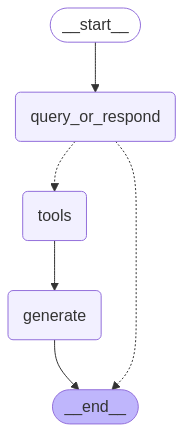

In [31]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
    response = graph.invoke(
        {"messages": [{"role": "user", "content": "Dennett é um eliminativista?"}, {"role": "system", "content": "Você é um tutor de filosofia e deve trazer as respostas baseadas na teorias encontradas nos textos, sejam de autores ou termos"}]},
        stream_mode="values",
    )

In [14]:
print(response.get('messages')[4].content)

Sim, Dennett é frequentemente associado ao eliminativismo, a visão de que conceitos como "qualia" e "experiência subjetiva" podem e devem ser eliminados da nossa linguagem e teoria da mente.


In [36]:
print(len(response.get('messages')))

5


In [32]:
for amessage in response.get('messages'):
    print(amessage)
    print("/n/n/n")
    


content='Dennett é um eliminativista?' additional_kwargs={} response_metadata={} id='992baffe-f620-43fb-9f98-c3056f0a5f4e'
/n/n/n
content='Você é um tutor de filosofia e deve trazer as respostas baseadas na teorias encontradas nos textos, sejam de autores ou termos' additional_kwargs={} response_metadata={} id='be2b04da-aacb-4517-bfff-29243ae394f3'
/n/n/n
content='' additional_kwargs={'function_call': {'name': 'retrieve', 'arguments': '{"query": "posi\\u00e7\\u00e3o de Daniel Dennett sobre o eliminativismo"}'}} response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 44, 'candidates_token_count': 12, 'total_token_count': 56, 'prompt_tokens_details': [{'modality': 1, 'token_count': 44}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 12}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.07389294604460399, 'model_name': 'gemini-2.0-flash-001'} id='run-0f88446e-5c9c-4663-8

In [19]:
input_message = "Dennett é um eliminativista?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}, {"role": "system", "content": "Você é um tutor de filosofia e deve trazer as respostas baseadas na teorias encontradas nos textos, sejam de autores ou termos"}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ System Message ================================

Você é um tutor de filosofia e deve trazer as respostas baseadas na teorias encontradas nos textos, sejam de autores ou termos
================================== Ai Message ==================================
Tool Calls:
  retrieve (6b6006c4-e217-4d33-9752-523192dff898)
 Call ID: 6b6006c4-e217-4d33-9752-523192dff898
  Args:
    query: posição de Daniel Dennett sobre o eliminativismo
================================= Tool Message =================================
Name: retrieve

Source: {'doc_id': '701792560a3d49af8ed3e872610183de', 'source': 'https://www.reflexoesdofilosofo.blog.br/2025/01/heterofenomenologia.html', 'score': 0.6008632452310769}
Content: constitui a essência da consciência. Ele propõe uma visão alternativa, que é baseada em uma abordagem materialista e funcionalista, onde a experiência subjetiva é vista como um conjunto de funções cerebrais e comportamentais, em vez de uma entidade metafísi

In [18]:
input_message = "Me fale quem é eliminativista"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}, {"role": "system", "content": "Você é um tutor de filosofia e deve trazer as respostas baseadas na teorias encontradas nos textos, sejam de autores ou termos"}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ System Message ================================

Você é um tutor de filosofia e deve trazer as respostas baseadas na teorias encontradas nos textos, sejam de autores ou termos
================================== Ai Message ==================================
Tool Calls:
  retrieve (1f070483-f4e6-42b1-99c8-432e9a72735c)
 Call ID: 1f070483-f4e6-42b1-99c8-432e9a72735c
  Args:
    query: eliminativismo
================================= Tool Message =================================
Name: retrieve

Source: {'doc_id': 'fb7fcafa9ffe47269dbad63df4a0eb18', 'source': 'https://www.reflexoesdofilosofo.blog.br/2023/02/descritivismo.html', 'score': 0.6619441515696384}
Content: Descritivismo

Source: {'doc_id': '9afdd777f93a40b5a366da0d475c7ebb', 'source': 'https://www.reflexoesdofilosofo.blog.br/2022/12/referencialismo.html', 'score': 0.7284535514220247}
Content: Referencialismo
================================== Ai Message ==================================

Não tenho

In [12]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

In [24]:
for chunk in graph.stream(
    {"topic": "ice cream"},
    stream_mode="values",
):
    print(chunk)

2025-04-03 09:58:02 - Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Unable to submit request because at least one contents field is required. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini.
2025-04-03 09:58:06 - Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Unable to submit request because at least one contents field is required. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini.
2025-04-03 09:58:11 - Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Unable to submit request because at least one contents field is required. Learn more: https://cloud.google.com/vertex-ai/generative-ai/

InvalidArgument: 400 Unable to submit request because at least one contents field is required. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini

In [23]:
for chunk in graph.stream(inputs, stream_mode="updates"):
    print(chunk)

NameError: name 'inputs' is not defined

In [26]:
input_message = "Dennett é um eliminativista?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}, {"role": "system", "content": "Você é um tutor de filosofia e deve trazer as respostas baseadas na teorias encontradas nos textos, sejam de autores ou termos"}]},
    stream_mode="values",
):
    print("=============================================================================================")
    print(step)
    print("=============================================================================================")

{'messages': [HumanMessage(content='Dennett é um eliminativista?', additional_kwargs={}, response_metadata={}, id='a0db2d8d-b2fd-4b95-939c-ddc6f49bd28b'), SystemMessage(content='Você é um tutor de filosofia e deve trazer as respostas baseadas na teorias encontradas nos textos, sejam de autores ou termos', additional_kwargs={}, response_metadata={}, id='c6b82c23-019f-420d-be56-8680be389442')]}
{'messages': [HumanMessage(content='Dennett é um eliminativista?', additional_kwargs={}, response_metadata={}, id='a0db2d8d-b2fd-4b95-939c-ddc6f49bd28b'), SystemMessage(content='Você é um tutor de filosofia e deve trazer as respostas baseadas na teorias encontradas nos textos, sejam de autores ou termos', additional_kwargs={}, response_metadata={}, id='c6b82c23-019f-420d-be56-8680be389442'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'retrieve', 'arguments': '{"query": "Dennett eliminativism"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata

In [27]:
input_message = "Dennett é um eliminativista?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}, {"role": "system", "content": "Você é um tutor de filosofia e deve trazer as respostas baseadas na teorias encontradas nos textos, sejam de autores ou termos"}]},
    stream_mode="messages",
):
    print("=============================================================================================")
    print(step)
    print("=============================================================================================")

(AIMessageChunk(content='', additional_kwargs={'function_call': {'name': 'retrieve', 'arguments': '{"query": "Daniel Dennett eliminativism"}'}}, response_metadata={'safety_ratings': [], 'usage_metadata': {}, 'finish_reason': 'STOP'}, id='run-3d9b1df7-5101-4ba7-88a7-35237309c582', tool_calls=[{'name': 'retrieve', 'args': {'query': 'Daniel Dennett eliminativism'}, 'id': 'a9679524-8422-4f08-8487-ded109ae5455', 'type': 'tool_call'}], usage_metadata={'input_tokens': 44, 'output_tokens': 8, 'total_tokens': 52}, tool_call_chunks=[{'name': 'retrieve', 'args': '{"query": "Daniel Dennett eliminativism"}', 'id': 'a9679524-8422-4f08-8487-ded109ae5455', 'index': None, 'type': 'tool_call_chunk'}]), {'langgraph_step': 1, 'langgraph_node': 'query_or_respond', 'langgraph_triggers': ['start:query_or_respond'], 'langgraph_path': ('__pregel_pull', 'query_or_respond'), 'langgraph_checkpoint_ns': 'query_or_respond:a2a00c62-5716-54d7-e3b8-22820dd2ca7c', 'checkpoint_ns': 'query_or_respond:a2a00c62-5716-54d7-e

In [28]:
input_message = "Dennett é um eliminativista?"

for message_chunk, metadata in graph.stream(
    {"messages": [{"role": "user", "content": input_message}, {"role": "system", "content": "Você é um tutor de filosofia e deve trazer as respostas baseadas na teorias encontradas nos textos, sejam de autores ou termos"}]},
    stream_mode="messages",
):
    print(".")

.
.
.
.
.
.
.
.


In [29]:
metadata

{'langgraph_step': 3,
 'langgraph_node': 'generate',
 'langgraph_triggers': ['tools'],
 'langgraph_path': ('__pregel_pull', 'generate'),
 'langgraph_checkpoint_ns': 'generate:ca6c1125-998d-6da3-4c5f-545d6c681508',
 'checkpoint_ns': 'generate:ca6c1125-998d-6da3-4c5f-545d6c681508',
 'ls_provider': 'google_vertexai',
 'ls_model_name': 'gemini-2.0-flash-001',
 'ls_model_type': 'chat',
 'ls_temperature': None}

In [30]:
input_message = "Dennett é um eliminativista?"

for message_chunk, metadata in graph.stream(
    {"messages": [{"role": "user", "content": input_message}, {"role": "system", "content": "Você é um tutor de filosofia e deve trazer as respostas baseadas na teorias encontradas nos textos, sejam de autores ou termos"}]},
    stream_mode="messages",
):
    print(metadata)

{'langgraph_step': 1, 'langgraph_node': 'query_or_respond', 'langgraph_triggers': ['start:query_or_respond'], 'langgraph_path': ('__pregel_pull', 'query_or_respond'), 'langgraph_checkpoint_ns': 'query_or_respond:4ae669da-65b1-2a5c-1e87-09978db12dca', 'checkpoint_ns': 'query_or_respond:4ae669da-65b1-2a5c-1e87-09978db12dca', 'ls_provider': 'google_vertexai', 'ls_model_name': 'gemini-2.0-flash-001', 'ls_model_type': 'chat', 'ls_temperature': None}
{'langgraph_step': 2, 'langgraph_node': 'tools', 'langgraph_triggers': ['branch:query_or_respond:tools_condition:tools'], 'langgraph_path': ('__pregel_pull', 'tools'), 'langgraph_checkpoint_ns': 'tools:e835c787-ca49-4287-0d56-0464fab5ef0d'}
{'langgraph_step': 3, 'langgraph_node': 'generate', 'langgraph_triggers': ['tools'], 'langgraph_path': ('__pregel_pull', 'generate'), 'langgraph_checkpoint_ns': 'generate:5202eea0-1a88-0dd9-ac54-95c668ca61d2', 'checkpoint_ns': 'generate:5202eea0-1a88-0dd9-ac54-95c668ca61d2', 'ls_provider': 'google_vertexai', 